<a href="https://colab.research.google.com/github/hoangdung3498/Voice_recognition_applications/blob/main/Voice_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nhận dạng giọng nói cho robot**

Tiền xử lí các tệp âm thanh ở định dạng WAV và xây dựng và đào tạo mô hình nhận dạng giọng nói tự động.Ở đây bọn em nhận dạng 8 từ khác nhau, đó là "down", "go", "left", "no", "right", "stop", "up" and "yes"

## Setup

import các thư viện cần thiết và các phụ thuộc

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import mini Speech Commands dataset

tải xuống và giải nến tệp mini_speech_commands.zip chứa bộ dữ liệu Speech Commands với tf.keras.utils.get_file:

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 1s 0us/step


Các đoạn âm thanh của tập dữ liệu được lưu trữ trong tám thư mục tương ứng với mỗi : `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['stop' 'no' 'yes' 'left' 'right' 'go' 'down' 'up']


Trích xuất các đoạn âm thanh thành một danh sách được gọi là 'filenames' và trộn nó lên:

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/ad6a46f1_nohash_0.wav', shape=(), dtype=string)


tách `filenames` thành các bộ training, validation and test sử dụng tỷ lệ 80:10:10 :

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Đọc các audio file và các label của nó

-tiền xử lý tập dữ liệu,tạo ra các tenxơ được giải mã cho waveforms và labels tương ứng.
 
shape của tensor được trả về bởi `tf.audio.decode_wav` là `[samples, channels]`, với `channels` là `1` cho mono hoặc `2` cho stereo.

In [ ]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

viết một hàm tiền xử lý các tệp âm thanh WAV của dataset thành các audio tensors:

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Xác định một hàm tạo nhãn

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

có hàm `get_waveform_and_label`kết hợp tất cả lại với nhau

- đầu vào là tên tệp âm thanh WAV.
- đầu ra là một bộ tuple chứa audio và label tensors sẵn sàng cho việc học có giám sát

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

xây dựng bộ training để chích xuất các cặp audio-label:

- tạo một`tf.data.Dataset` với `Dataset.from_tensor_slices` và `Dataset.map`, sử dụng `get_waveform_and_label` đã xác định trước đó. 

xây dựng bộ validation và test tương tự

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

vẽ một vài audio waveforms:




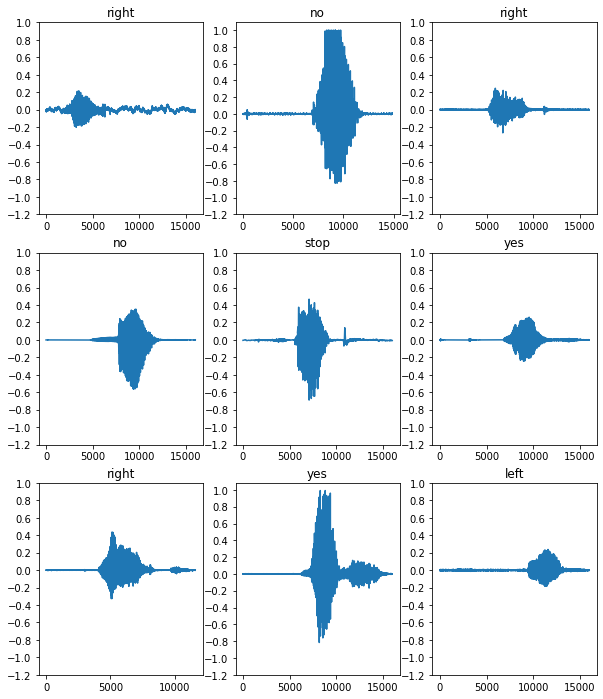

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Chuyển đổi waveforms thành spectrograms

Các waveform trong dataset được biểu diễn trong miền thời gian.Sau đó sẽ biến đổi các waveform từ tín hiệu miền thời gian thành tín hiệu miền tần số thời gian,các spectrogram.Sau đó cung cấp các hình ảnh spectrogram vào mạng nơ-ron để huấn luyện mô hình.





In [ ]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In các shape của tensorized waveform và spectrogram tương ứng của một ví dụ, và phát âm thanh gốc:

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


xác định một hàm để hiển thị một spectrogram :

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Vẽ waveform và spectrogram:

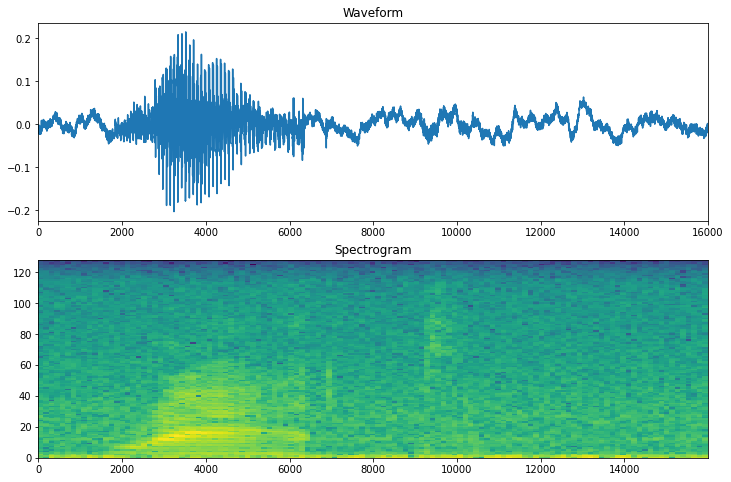

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

xác định một hàm biến đổi waveform dataset thành các spectrogram và các nhãn tương ứng của chúng:

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` trên các phần tử của dataset elements với `Dataset.map`:

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Kiểm tra các biểu đồ quang phổ

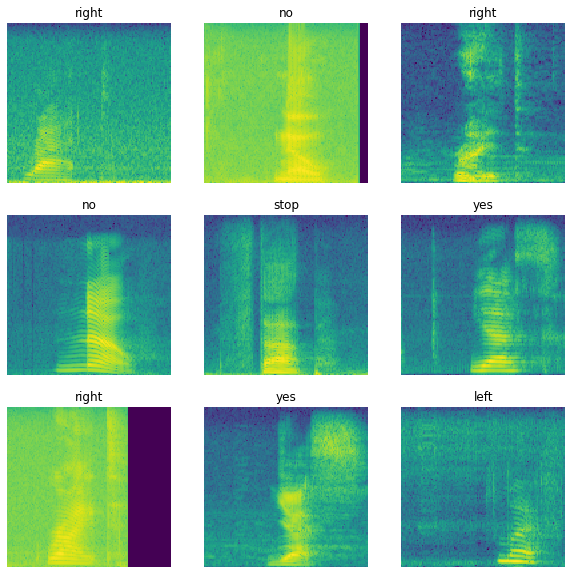

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build and train the model

Viết một hàm tổng hợp những công việc trên và lặp lại quá trình tiền xử lý bộ training áp dụng trên bộ validation và test:

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch các bộ training and validation cho model training:

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

thêm các operation`Dataset.cache` và `Dataset.prefetch` để giảm độ trễ đọc trong khi training model:

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Về phần model, sử dụng convolutional neural network (CNN)

tf.keras.Sequential model sẽ sử dụng các lớp tiền xử lý sau của Keras: 

tf.keras.layers.Resizing: giảm bớt kích cỡ mẫu đầu vào để cho phép mô hình đào tạo nhanh hơn. 

tf.keras.layers.Normalization: để chuẩn hóa từng pixel trong hình ảnh dựa trên giá trị trung bình(mean) và độ lệch chuẩn của nó (standard deviation). Đối với lớp  Normalization, adapt method của nó trước tiên cần được gọi trên  training data để tính aggregate statistics (nghĩa là mean và standard deviation).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

 cấu hình mô hình Keras với Adam optimizer và cross-entropy loss:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

train mô hình 10 Epochs 

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
model.save("mymodel.h5")

Epoch 1/10
100/100 [==============================] - 37s 360ms/step - loss: 1.7441 - accuracy: 0.3719 - val_loss: 1.2437 - val_accuracy: 0.6037
Epoch 2/10
100/100 [==============================] - 20s 195ms/step - loss: 1.1523 - accuracy: 0.5866 - val_loss: 0.8764 - val_accuracy: 0.6938
Epoch 3/10
100/100 [==============================] - 21s 213ms/step - loss: 0.8732 - accuracy: 0.6852 - val_loss: 0.7319 - val_accuracy: 0.7575
Epoch 4/10
100/100 [==============================] - 19s 194ms/step - loss: 0.7092 - accuracy: 0.7416 - val_loss: 0.6626 - val_accuracy: 0.7763
Epoch 5/10
100/100 [==============================] - 19s 194ms/step - loss: 0.6294 - accuracy: 0.7773 - val_loss: 0.6345 - val_accuracy: 0.7875
Epoch 6/10
100/100 [==============================] - 20s 195ms/step - loss: 0.5563 - accuracy: 0.8031 - val_loss: 0.6072 - val_accuracy: 0.7937
Epoch 7/10
100/100 [==============================] - 19s 195ms/step - loss: 0.5009 - accuracy: 0.8206 - val_loss: 0.5438 - val_ac

vẽ các đường cong mất training và validation để kiểm tra cách mô hình đã được cải thiện trong quá trình training:

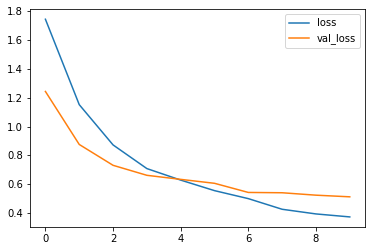

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate the model performance

Chạy model trên bộ test và kiểm tra hiệu suất của model:

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 83%


### Display a confusion matrix

Sử dụng confusion matrix để kiểm tra xem model đã phân loại tốt như thế nào mỗi command trong bộ test:


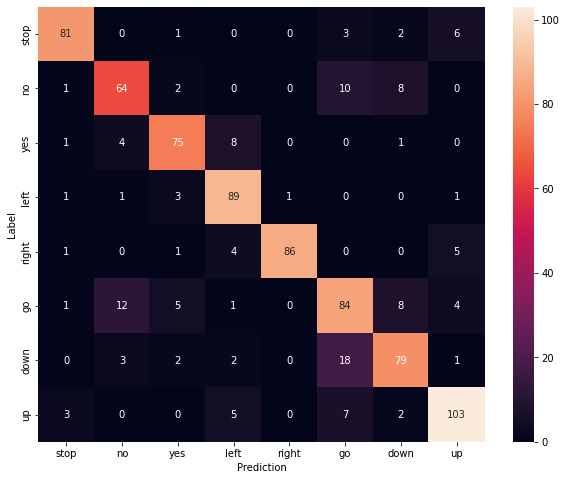

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Cuối cùng, xác minh model's prediction bằng cách sử dụng một input audio file

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

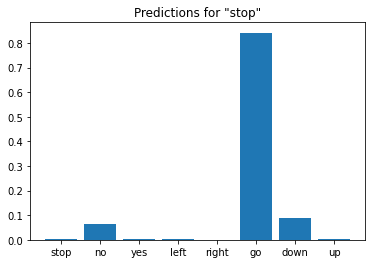

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
newmodel = tf.keras.models.load_model('mymodel.h5')
newmodel.summary()

sample_file = data_dir/'go.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = newmodel(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
print(test_files)

tf.Tensor(
[b'data/mini_speech_commands/right/8eb4a1bf_nohash_1.wav'
 b'data/mini_speech_commands/up/5b09db89_nohash_1.wav'
 b'data/mini_speech_commands/left/cdfbbe75_nohash_0.wav'
 b'data/mini_speech_commands/go/73cccfaf_nohash_0.wav'
 b'data/mini_speech_commands/stop/28ce0c58_nohash_4.wav'
 b'data/mini_speech_commands/up/10ace7eb_nohash_4.wav'
 b'data/mini_speech_commands/yes/1eddce1d_nohash_1.wav'
 b'data/mini_speech_commands/down/d750966e_nohash_0.wav'
 b'data/mini_speech_commands/right/91d5933a_nohash_0.wav'
 b'data/mini_speech_commands/down/f59d0771_nohash_2.wav'
 b'data/mini_speech_commands/stop/94de6a6a_nohash_1.wav'
 b'data/mini_speech_commands/up/0135f3f2_nohash_1.wav'
 b'data/mini_speech_commands/left/c256377f_nohash_1.wav'
 b'data/mini_speech_commands/left/8dd788d8_nohash_0.wav'
 b'data/mini_speech_commands/right/c79159aa_nohash_0.wav'
 b'data/mini_speech_commands/up/cb8f8307_nohash_0.wav'
 b'data/mini_speech_commands/up/0f250098_nohash_0.wav'
 b'data/mini_speech_commands/r